<a href="https://colab.research.google.com/github/MelAGndy/main/blob/Python/twitter_apple_google_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Designing a reliable product sentiment analyzer: a classification of Tweets regarding Apple and Google

## Business value: 
Being able to reliably classify tweets allows for a jumping off point for further analysis and modeling, as well as more ability to choose which tweets to examine for other use cases.

## Business use case: 
By identifying the negative and positive sentiments about Apple and Google, a tech business from the outside would be able to better understand the strategies, successes and blunders in the eye of the public for two tech giants. This would allow them to better their business by avoiding past mistakes or customer paint points and bouncing off of the successes of these companies.

## Evaluation: 

Cohen's Kappa score has been chosen as the metric of evaluation, especially fit for the imbalanced dataset and measuring the reliability of the classifier, how precise it is compared to being rated by chance. A robust and reliable classifier is needed for this business case due to how noisy and complicated twitter data can be. 

- Landis and Koch's guidelines for interpreting Kappa:
     - > <0 as indicating no agreement
     - > 0.00–0.20 as slight, 
     - > 0.21–0.40 as fair, 
     - > 0.41–0.60 as moderate, 
     - > 0.61–0.80 as substantial, and 
     - > 0.81–1 as almost perfect agreement. 

- Fleiss's guidelines:

    - > 0.75+ as excellent, 
    - > 0.40 to 0.75 as fair to good, and 
    - > <0.40 as poor. 

# Imports and reading in data: 

In [ ]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import TSNEVisualizer
from yellowbrick.text import freqdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

Using TensorFlow backend.
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn import metrics
import missingno as msno
import plotly.express as px

In [ ]:
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import time
from nltk import FreqDist
from scipy.stats import entropy

In [ ]:
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings("ignore")

## Reading in data

In [ ]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

tweet_text  \
0   .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1   @jessedee Know about @fludapp ? Awesome iPad/i...   
2   @swonderlin Can not wait for #iPad 2 also. The...   
3   @sxsw I hope this year's festival isn't as cra...   
4   @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5   @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                 NaN   
7   #SXSW is just starting, #CTIA is around the co...   
8   Beautifully smart and simple idea RT @madebyma...   
9   Counting down the days to #sxsw plus strong Ca...   
10  Excited to meet the @samsungmobileus at #sxsw ...   
11  Find &amp; Start Impromptu Parties at #SXSW Wi...   
12  Foursquare ups the game, just in time for #SXS...   
13  Gotta love this #SXSW Google Calendar featurin...   
14  Great #sxsw ipad app from @madebymany: http://...   
15  haha, awesomely rad iPad app by @madebymany ht...   
16  Holler Gram for iPad on the iTunes App Store -...   
17  I just noticed DST is coming this weekend. How...   
18  Just added my #SXSW flights to @planely. Match...   
19  Must have #SXSW app! RT @malbonster: Lovely re...   

    emotion_in_tweet_is_directed_at  \
0                            iPhone   
1                iPad or iPhone App   
2                              iPad   
3                iPad or iPhone App   
4                            Google   
5                               NaN   
6                               NaN   
7                           Android   
8                iPad or iPhone App   
9                             Apple   
10                          Android   
11                      Android App   
12                      Android App   
13  Other Google product or service   
14               iPad or iPhone App   
15               iPad or iPhone App   
16                              NaN   
17                           iPhone   
18               iPad or iPhone App   
19               iPad or iPhone App   

   is_there_an_emotion_directed_at_a_brand_or_product  
0                                    Negative emotion  
1                                    Positive emotion  
2                                    Positive emotion  
3                                    Negative emotion  
4                                    Positive emotion  
5                  No emotion toward brand or product  
6                  No emotion toward brand or product  
7                                    Positive emotion  
8                                    Positive emotion  
9                                    Positive emotion  
10                                   Positive emotion  
11                                   Positive emotion  
12                                   Positive emotion  
13                                   Positive emotion  
14                                   Positive emotion  
15                                   Positive emotion  
16                 No emotion toward brand or product  
17                                   Negative emotion  
18                                   Positive emotion  
19                                   Positive emotion

In [ ]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

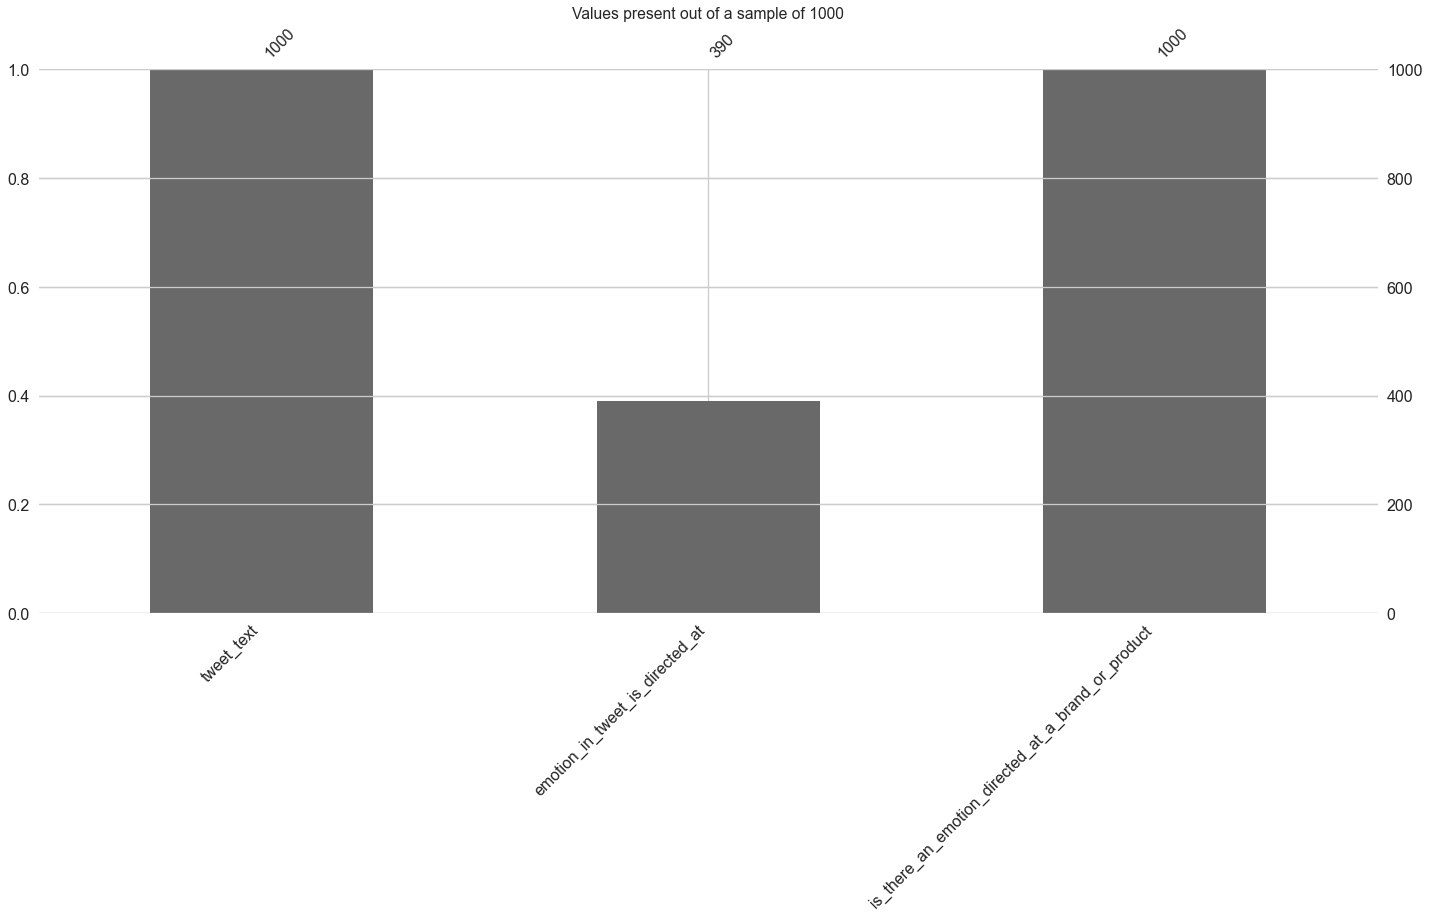

In [ ]:
msno.bar(df.sample(1000))
ax = plt.gca()
ax.set_title("Values present out of a sample of 1000")
plt.show()

## Dropping product/company tweet emotion is directed at
### Rationale: 
Dropping this feature to focus on the text itself and later, statistics regarding the text, to make a more generalizable classifier than including information about the direction of the tweet, as well as a significant amount of null values compromising this feature.

In [ ]:
df = df.drop('emotion_in_tweet_is_directed_at', axis=1)

df.isnull().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

## Severe class imbalance of Neutral type tweets vs. Positive and especially Negative tweets

In [ ]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

Text(0.5, 1.0, 'Values present out of a sample of 1000 - after cleaning')

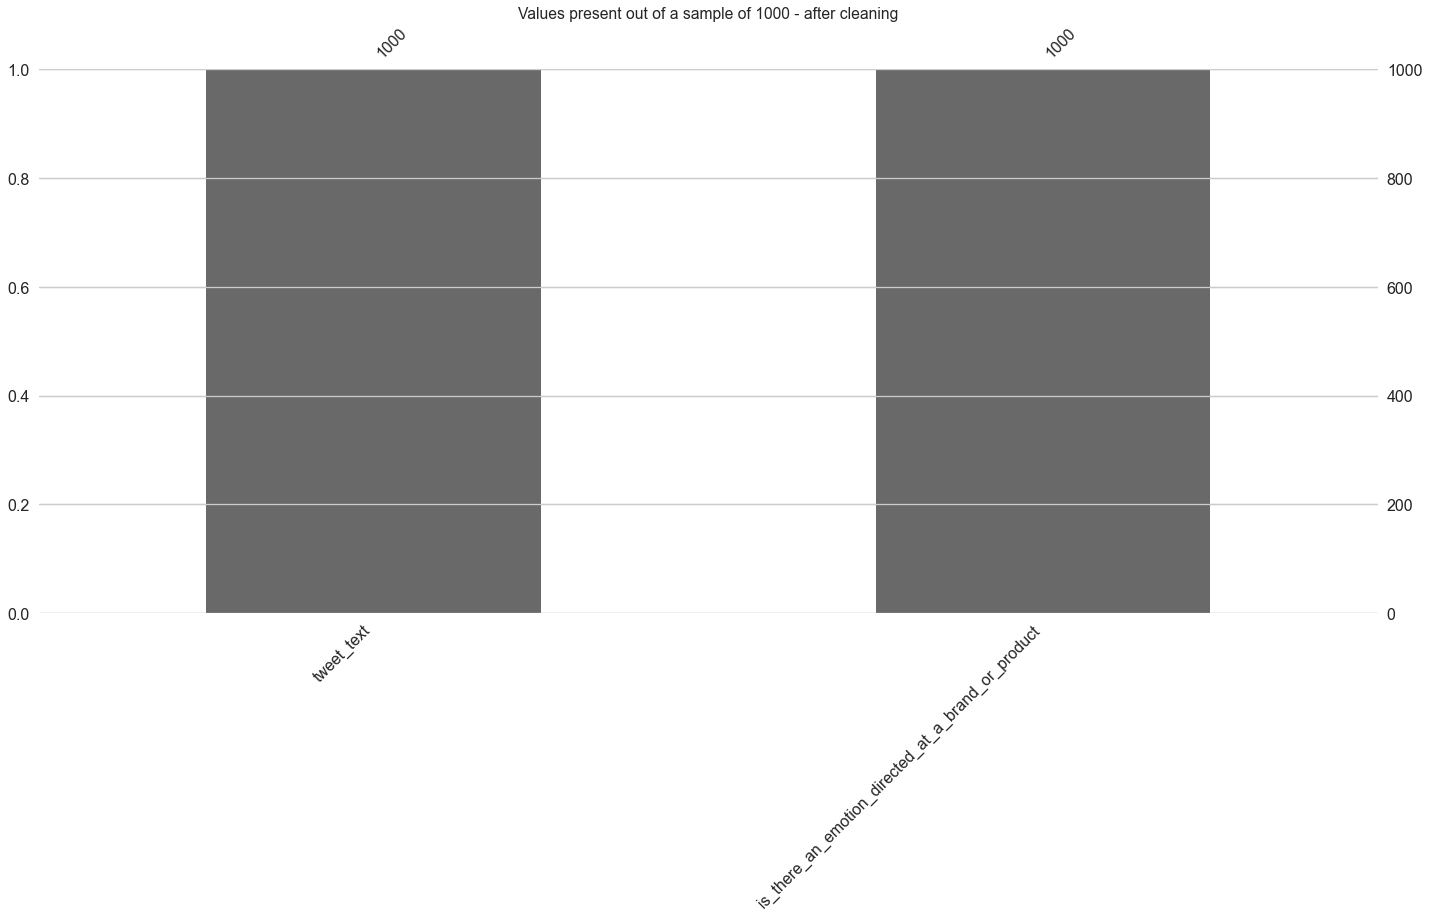

In [ ]:
msno.bar(df.sample(1000))
ax = plt.gca()
ax.set_title("Values present out of a sample of 1000 - after cleaning")

# Preprocessing and EDA

## Renaming columns for easier reference

In [ ]:
df = df.rename(columns={"tweet_text": "text", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})
df

text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                               sentiment  
0                       Negative emotion  
1                       Positive emotion  
2                       Positive emotion  
3                       Negative emotion  
4                       Positive emotion  
...                                  ...  
9088                    Positive emotion  
9089  No emotion toward brand or product  
9090  No emotion toward brand or product  
9091  No emotion toward brand or product  
9092  No emotion toward brand or product  

[9092 rows x 2 columns]

## Mapping sentiment to increasingly positive: 0 for negative, 1 for neutral, 2 for positive

In [ ]:
df.sentiment = df.sentiment.map({'Positive emotion': 2, 'Negative emotion': 0, 'No emotion toward brand or product': 1, "I can't tell":1})

In [ ]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

## Countplot shows that the majority of tweets are neutral, then positive, then few negative tweets

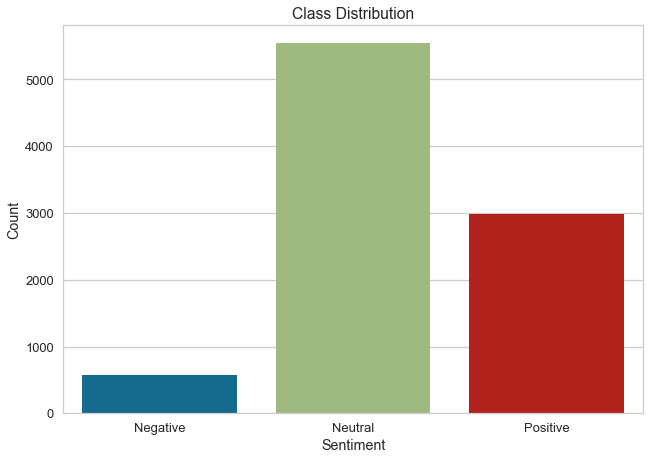

In [ ]:
sns.countplot(df.sentiment)
ax = plt.gca()
ax.set_title("Class Distribution")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_xticklabels(['Negative','Neutral','Positive'])
plt.show()

## General text preprocessing function, creating a new dataframe(clean_df) to preserve the original text

In [ ]:
def preprocess(text):
    '''Replaces various punctuation and special characters not helpful to analysis or meaningful'''
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    text = text.str.replace(',','')
    text = text.str.replace('{', '')
    text = text.str.replace('}', '')
    text = text.str.replace('.', '')
    text = text.str.replace(':', '')
    text = text.str.replace('-', '')
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

## Creating new features
Creating features out of the length of a tweet, words in a tweet, and amounts of hashtags, capital words, exclamation/question marks, the mean length of a word in a tweet, the count of unique words in a tweet, and the percentage of unique words in a tweet.

In [ ]:
def tweet_special_count(string, character):
    '''Splits string by word, and returns the count of a given character starting a tweet'''
    w = string.split()
    
    char = [word for word in w if word.startswith(character)]
    
    return len(char)

In [ ]:
#gathering length of each tweet's string into feature
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)

#splitting length to derive word count
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))

#applying tweet_special count on hashtags and mentions(@)
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))

#use of regex to identify capital letters starting a word group and exclamation/question marks
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))

#takes length of split words and calculates mean word length
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#length of the Python Set of a split string to derive unique words' count
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))

#count of unique words within a tweet
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']

clean_df.head()



text  sentiment  tweet_len  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0        122   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2        137   
2  @swonderlin Can not wait for #iPad 2 also They...          2         77   
3  @sxsw I hope this year's festival isn't as cra...          0         81   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2        125   

   tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
0           23         2            1              1             1   
1           22         1            2              1             1   
2           15         2            1              1             0   
3           15         1            1              0             0   
4           17         1            1              1             0   

   mean_word_len  count_unique_word  word_unique_percent  
0       4.304348                 21            91.304348  
1       5.272727                 22           100.000000  
2       4.200000                 15           100.000000  
3       4.466667                 12            80.000000  
4       6.411765                 17           100.000000

In [ ]:
clean_df.columns

Index(['text', 'sentiment', 'tweet_len', 'tweet_words', 'hash_cnt',
       'mention_cnt', 'capital_words', 'excl_q_marks', 'mean_word_len',
       'count_unique_word', 'word_unique_percent'],
      dtype='object')

# Summary stats and visuals

## Top tokens - items and products with named entity recognition

In [ ]:
df.text

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

In [ ]:
#tokenizing with Spacy's default parser for NER(Named Entity Recognition) purposes as Spacy is especially fit for this

from collections import Counter
tokens = nlp(''.join(str(df.text.tolist())))

#extracting items with entities in their tokens and displaying the 20 most commmon
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('Apple', 1122),
 ('iPhone', 843),
 ('Google', 775),
 ('SXSW', 750),
 ('Austin', 642),
 ('2', 490),
 ('today', 301),
 ('#sxsw #', 266),
 ('Today', 235),
 ('#sxsw', 234),
 ('Android', 232),
 ('#SXSW #', 232),
 ('sxsw', 152),
 ('Launch Major New Social Network', 152),
 ('Circles', 142),
 ('RT @mention', 138),
 ('SxSW', 107),
 ('iPad2', 95),
 ('RT @mention Google', 94),
 ("'RT @mention", 94)]

## Between Apple and its iPad 2, Apple seems to dominate over Google in this dataset. 
Of interest is "Circles", the new Google social network launch rumored at the time (evidently during South by Southwest Festival in Austin, Texas in 2011:
- https://www.forbes.com/sites/davidewalt/2011/03/11/lines-form-at-apples-sxsw-pop-up-store-in-austin/
- https://en.wikipedia.org/wiki/IPad_2
- https://siliconangle.com/2011/03/13/google-circles-brings-privacy-full-circle-preview-at-sxsw/

### Most common tokens W/ identified Entities

In [ ]:
item_cnt = Counter(items).most_common(20)
df_items = pd.DataFrame(item_cnt, columns =['text', 'count'])


fig = px.bar(df_items, y="text", x="count", orientation='h',title="Most Common Tokens W/ Entities Mentioned")
fig.show()

### Most Common Products

In [ ]:
products = []
for ent in tokens.ents:
    if ent.label_ == 'PRODUCT':
        products.append(ent.text)
        
prdct_cnt = Counter(products).most_common(20)
df_prod = pd.DataFrame(prdct_cnt, columns =['text', 'count'])

fig = px.bar(df_prod, y="text", x="count", orientation='h',title="Most Common Products Mentioned")
fig.show()

## Analysis of numerical features-
### Distributions:
Tweet length, amount of words in tweet, and count of unique words stand out they as look Gaussian/normal.

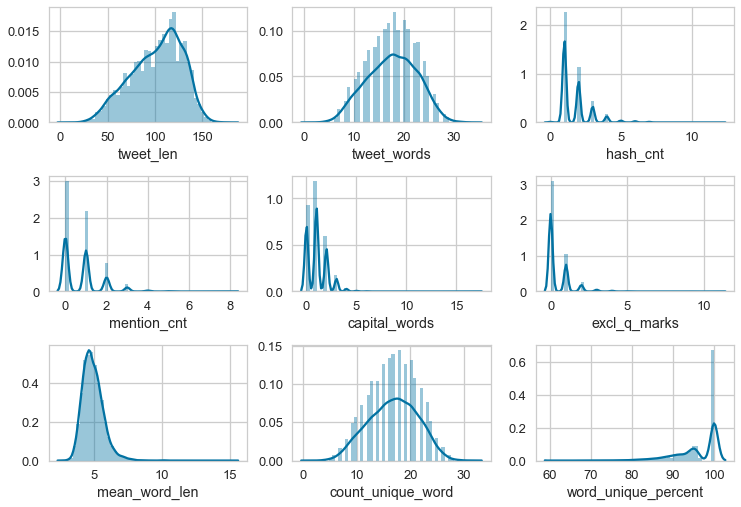

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

### Correlation matrix - looks like not much correlation/colinearity, no values above +.30 and none below -.45

Text(0.5, 1.0, 'Correlation of numerical features(diagonal removed)')

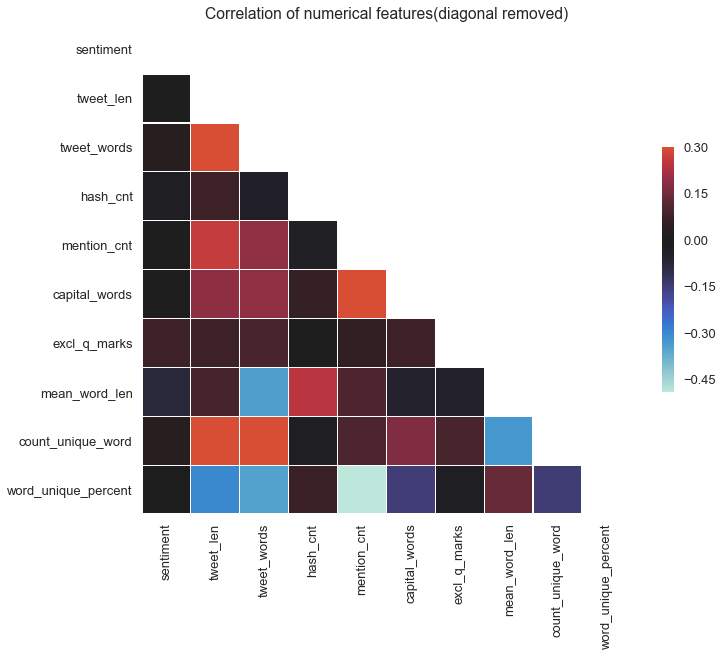

In [ ]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax = plt.gca()
ax.set_title("Correlation of numerical features(diagonal removed)")

### Pairplot
#### Interpretation:
Tweet_len stands out as looking to have correlation on a visual level with other features.

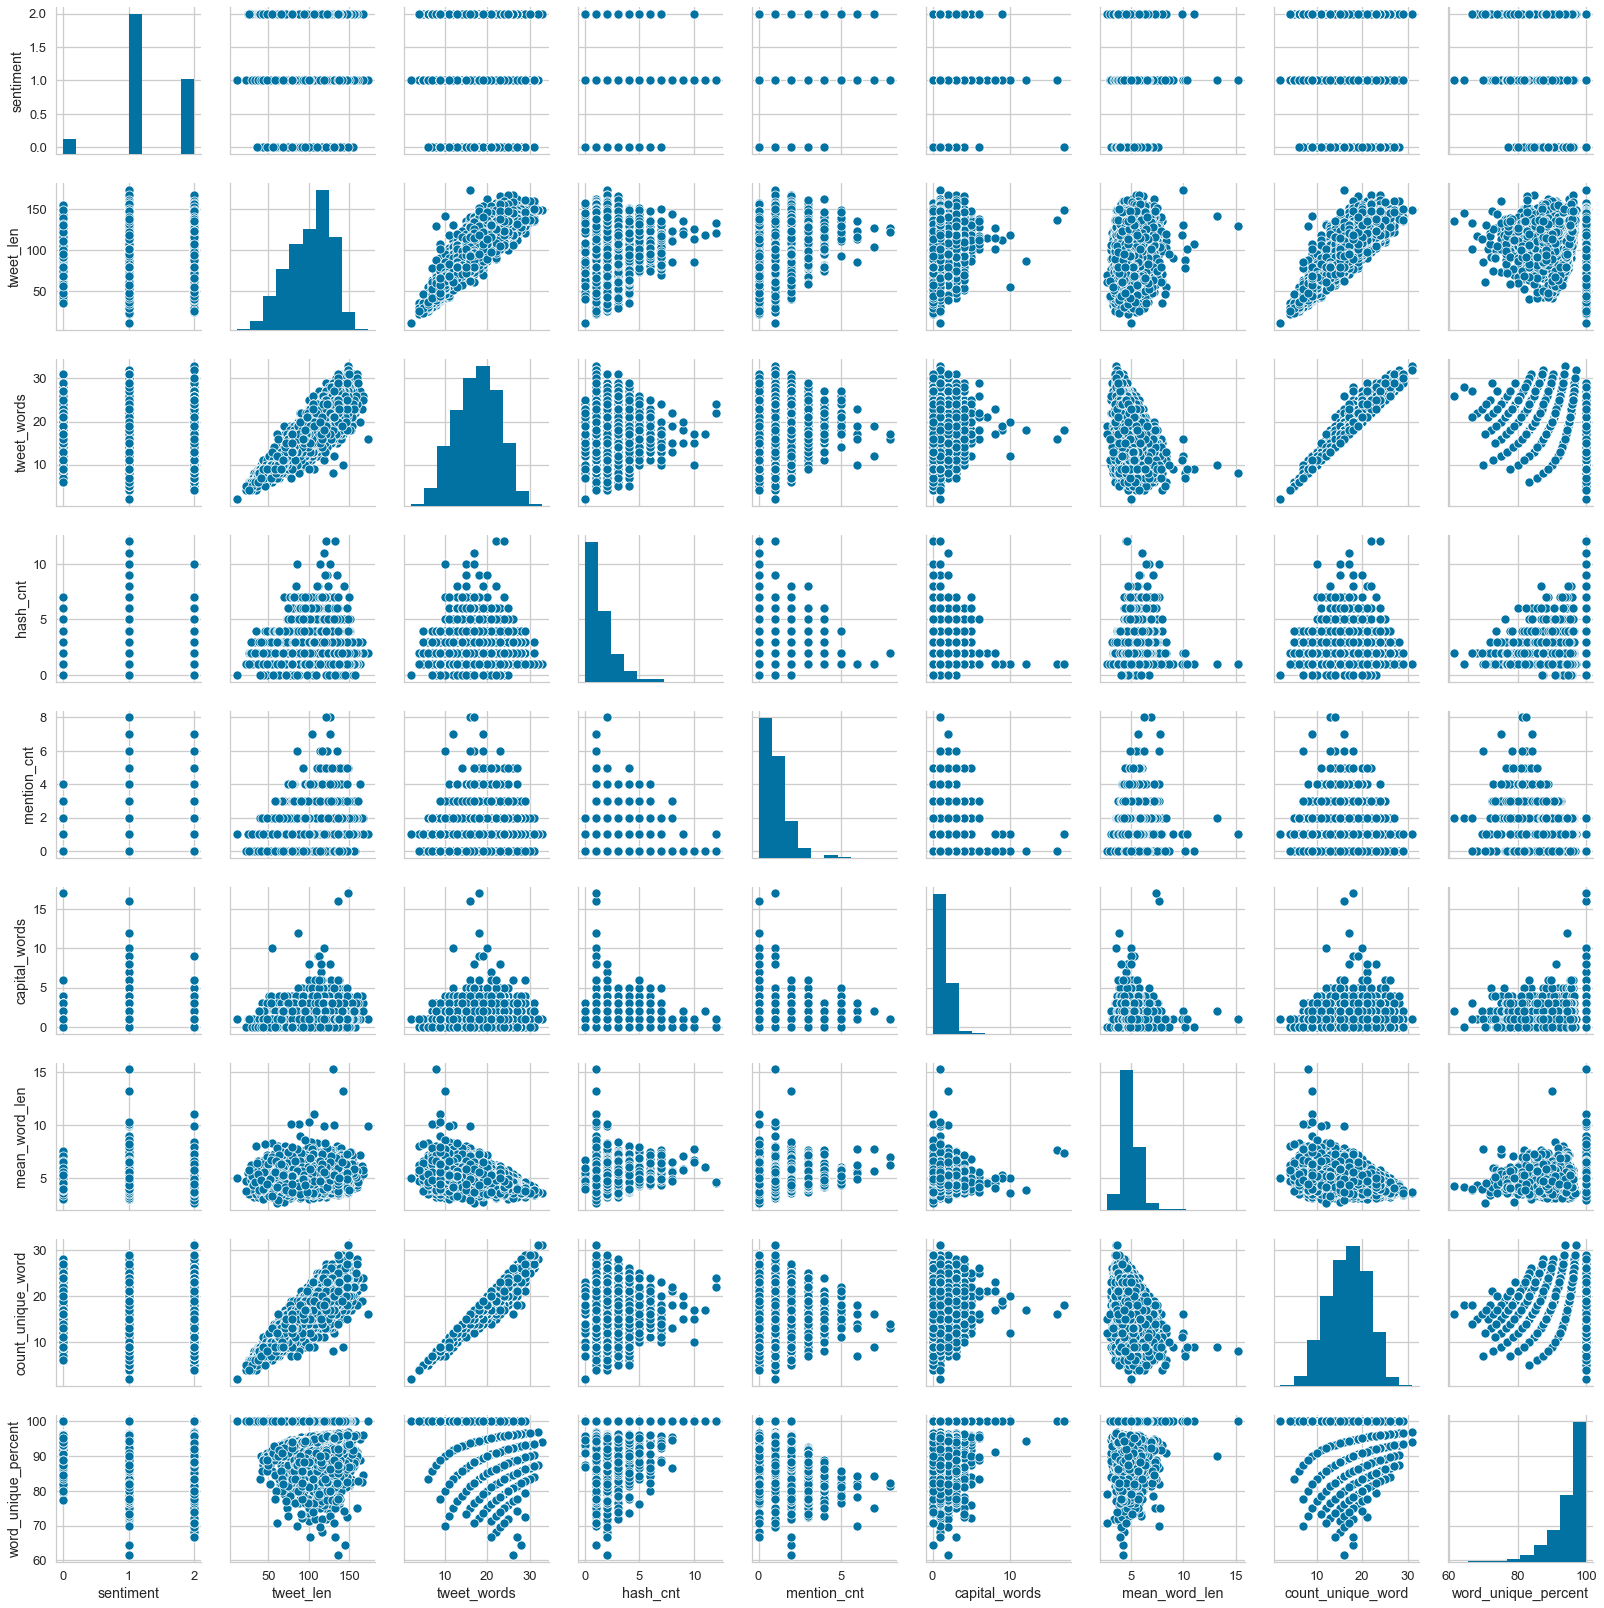

In [ ]:
sns.pairplot(clean_df[[ 'sentiment', 'tweet_len','tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words','mean_word_len', 'count_unique_word', 'word_unique_percent']])

#### Dropping tweet_len due to high correlation with tweet_words and unique words

In [ ]:
clean_df = clean_df.drop('tweet_len',axis=1)

clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0           23   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2           22   
2  @swonderlin Can not wait for #iPad 2 also They...          2           15   
3  @sxsw I hope this year's festival isn't as cra...          0           15   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2           17   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.304348   
1         1            2              1             1       5.272727   
2         2            1              1             0       4.200000   
3         1            1              0             0       4.466667   
4         1            1              1             0       6.411765   

   count_unique_word  word_unique_percent  
0                 21            91.304348  
1                 22           100.000000  
2                 15           100.000000  
3                 12            80.000000  
4                 17           100.000000

# Further preprocessing - tokenizing and lemmatizing, stopword removal

In [ ]:
clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

## Initial Wordcloud for comparison of prominent text

In [ ]:
from wordcloud import WordCloud

### Creating initial wordcloud

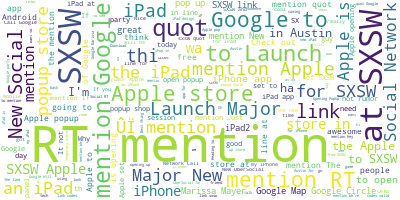

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

## Sentence by sentence stemming and visualization

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def stem_sentences(sentence):
    '''splits sentence by word and then lemmatizes each word before joining the lemmatized tokens'''
    tokens = sentence.split()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemma_tokens)

clean_df['text'] = clean_df['text'].apply(stem_sentences)

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hr tweeti...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't a cras...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customer complained their ...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

### Word cloud begins to show changes

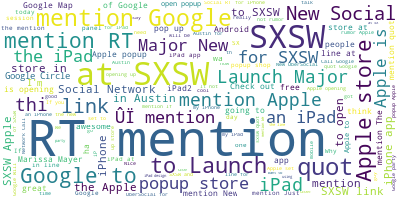

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

## Removal of stopwords and corresponding visual

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelburak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
clean_df['text'] = clean_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

clean_df['text']

0       @wesley83 I 3G iPhone After 3 hr tweeting #RIS...
1       @jessedee Know @fludapp ? Awesome iPad/iPhone ...
2       @swonderlin Can wait #iPad 2 also They sale #SXSW
3       @sxsw I hope year's festival crashy year's iPh...
4       @sxtxstate great stuff Fri #SXSW Marissa Mayer...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt regularly s...
9090    Google's Zeiger physician never reported poten...
9091    Some Verizon iPhone customer complained time f...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

### Wordcloud shows some removed words such as 'at' that are stopwords

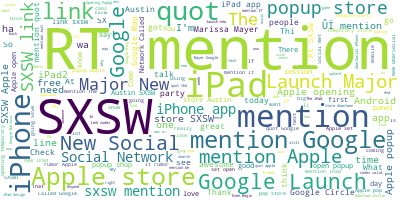

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

## Wordclouds by Sentiment

In [ ]:
pos_df = clean_df[clean_df['sentiment'] == 2]
neg_df = clean_df[clean_df['sentiment'] == 0]
neu_df = clean_df[clean_df['sentiment'] == 1]

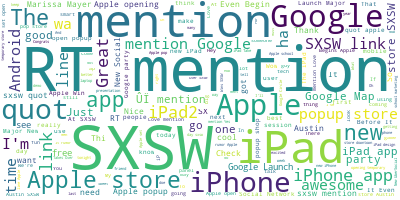

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(pos_df['text'].to_string())

wordcloud.to_image()

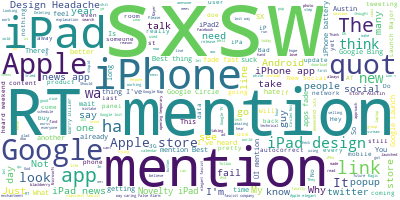

In [ ]:
wordcloud.generate(neg_df['text'].to_string())

wordcloud.to_image()

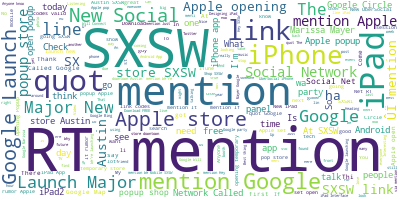

In [ ]:
wordcloud.generate(neu_df['text'].to_string())

wordcloud.to_image()

# Features after cleaning and analysis

In [ ]:
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I 3G iPhone After 3 hr tweeting #RIS...          0           17   
1  @jessedee Know @fludapp ? Awesome iPad/iPhone ...          2           16   
2  @swonderlin Can wait #iPad 2 also They sale #SXSW          2            9   
3  @sxsw I hope year's festival crashy year's iPh...          0           10   
4  @sxtxstate great stuff Fri #SXSW Marissa Mayer...          2           16   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.882353   
1         1            2              1             1       5.812500   
2         2            1              1             0       4.555556   
3         1            1              0             0       5.000000   
4         1            1              1             0       6.687500   

   count_unique_word  word_unique_percent  
0                 16            94.117647  
1                 16           100.000000  
2                  9           100.000000  
3                  9            90.000000  
4                 16           100.000000

## Distribution of features: 
The distribution of features remains similar, likely due to mostly preserving word content.

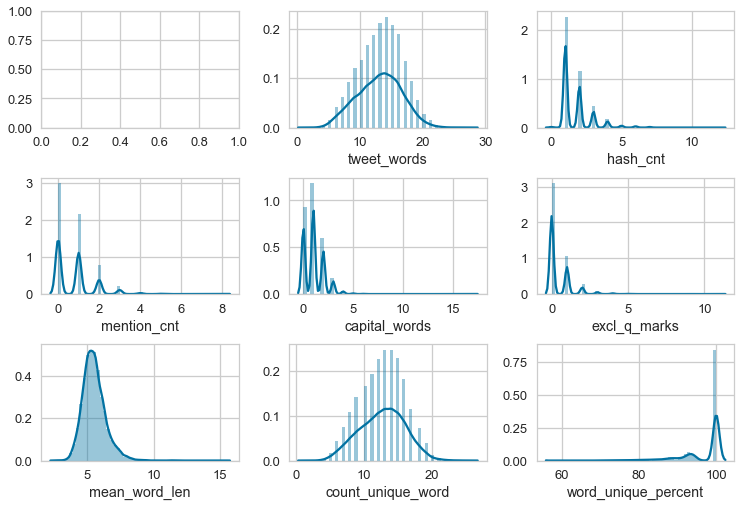

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

## Tokenizing with TweetTokenizer from NLTK

In [ ]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
clean_df['tokens'] = clean_df['text'].apply(tt.tokenize)

# Visuals, continued - t-Sne

## t-SNE of k-means clusters, overall document, text vs. classes

In [ ]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(clean_df['text'])

tf_words = tfidf.get_feature_names()


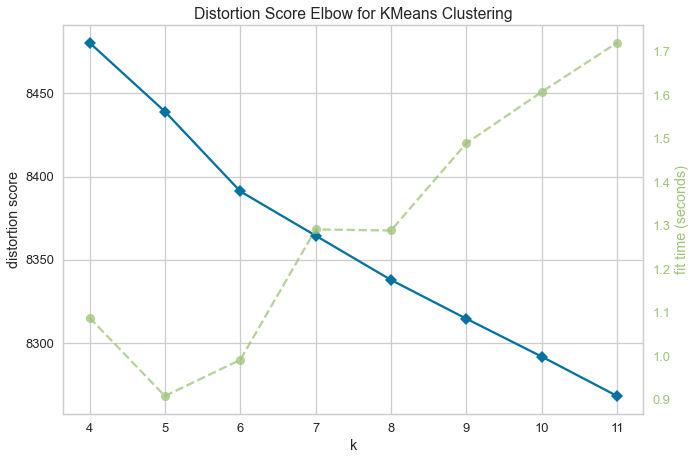

In [ ]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)
visualizer.show() 

### t-SNE of K-means

In [ ]:
from yellowbrick.text import TSNEVisualizer


In [ ]:
clusters = KMeans(n_clusters=7)
clusters.fit(X)


KMeans(n_clusters=7)

### Interpretation:
Of special interest are groups of words regarding the rumored launch of Google's "Circles" and a special Apple popup store in Austin that seems popular. More analysis needs to go into the positioning and relationship of clusters in future work.

W0710 09:27:45.443063 4574641600 _axes.py:4229] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0710 09:27:45.465797 4574641600 _axes.py:4229] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
W0710 09:27:45.488970 4574641600 _axes.py:4229] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide 

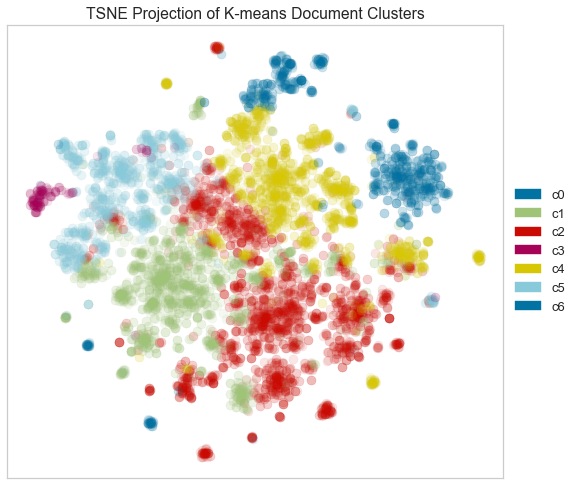

0 : quot, mention, sxsw, google, rt, ipad, apple, heard, link, go
1 : ipad, mention, sxsw, link, rt, win, the, new, design, app
2 : mention, iphone, sxsw, link, app, android, rt, free, new, apple
3 : opening, downtown, temporary, austin, launch, store, apple, rumor, mention, it
4 : google, mention, sxsw, link, rt, circles, party, mayer, mobile, marissa
5 : apple, store, popup, sxsw, link, mention, austin, ipad2, line, open
6 : network, social, circles, called, launch, major, new, today, possibly, google


In [ ]:
tsne = TSNEVisualizer(size=(800, 600), title="TSNE Projection of K-means Document Clusters", alpha=0.1,random_state=0)
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()    
common_words = clusters.cluster_centers_.argsort()[:,-1:-11:-1]

for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tf_words[word] for word in centroid))


### TSNE of tweet text
### Interpretation: 
The documents cluster very much around the center, but there are plenty of outlying documents.

W0710 09:31:06.363123 4574641600 _axes.py:4229] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


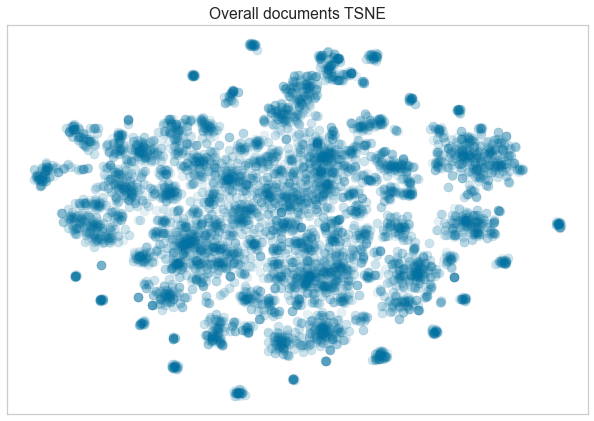

In [ ]:
tsne = TSNEVisualizer(random_state=0,alpha=0.1, title="Overall documents TSNE")
tsne.fit(X)
tsne.show()

### TSNE of tweet text and sentiment
### Interpretation:
Neutral sentiment dominates, fitting with the class imbalance. Negative classes can hardly be seen in this projection, while there are some outlying positive class records.

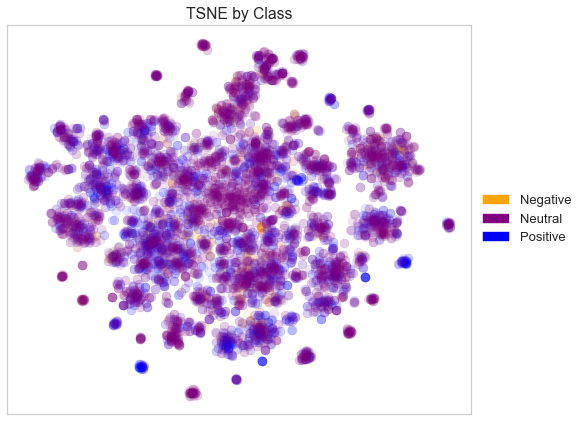

In [ ]:
y = clean_df['sentiment'].replace({0:"Negative",1:"Neutral",2:"Positive"})
tsne = TSNEVisualizer(random_state=0, title="TSNE by Class",colors=('orange','purple','blue'), alpha=0.1)
tsne.fit(X,y)

tsne.show()

### Word modeling t-SNE

In [ ]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [ ]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(clean_df)        
corpus[0:2]

[['@wesley83',
  'I',
  '3G',
  'iPhone',
  'After',
  '3',
  'hr',
  'tweeting',
  '#RISE_Austin',
  'wa',
  'dead!',
  'I',
  'need',
  'upgrade',
  'Plugin',
  'station',
  '#SXSW'],
 ['@jessedee',
  'Know',
  '@fludapp',
  '?',
  'Awesome',
  'iPad/iPhone',
  'app',
  'likely',
  'appreciate',
  'design',
  'Also',
  "they're",
  'giving',
  'free',
  'Ts',
  '#SXSW']]

In [ ]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['Google']

array([-0.35721922,  0.38029787, -0.0017054 , -0.14036466, -0.3450604 ,
        0.12465498,  0.20783202,  0.17083216,  0.1162537 , -0.13691185,
       -0.25569242, -0.01330966, -0.10891853,  0.11587822,  0.02181071,
        0.24475095,  0.14155893,  0.17167075,  0.40459523, -0.00256917,
        0.19891404,  0.31875393,  0.17907824, -0.13605583,  0.18064259,
        0.05117822,  0.3560336 , -0.20329417, -0.08889126,  0.0704571 ,
       -0.05889035, -0.42823556,  0.17462614,  0.1393288 ,  0.19317879,
       -0.21138626,  0.13402474, -0.01310829, -0.06552285, -0.13617261,
        0.14665139, -0.22662021,  0.09301969, -0.02166477,  0.12846705,
       -0.14920841,  0.4244535 ,  0.11193795,  0.10518481, -0.06095101,
       -0.04023816, -0.13148572, -0.00660596, -0.28786892,  0.17682967,
       -0.10909624,  0.20413813,  0.08538721, -0.37958002, -0.13964191,
        0.24158522, -0.16315116,  0.5102127 , -0.22061087,  0.09739709,
        0.1456021 , -0.13230674, -0.33138233,  0.2111623 ,  0.19

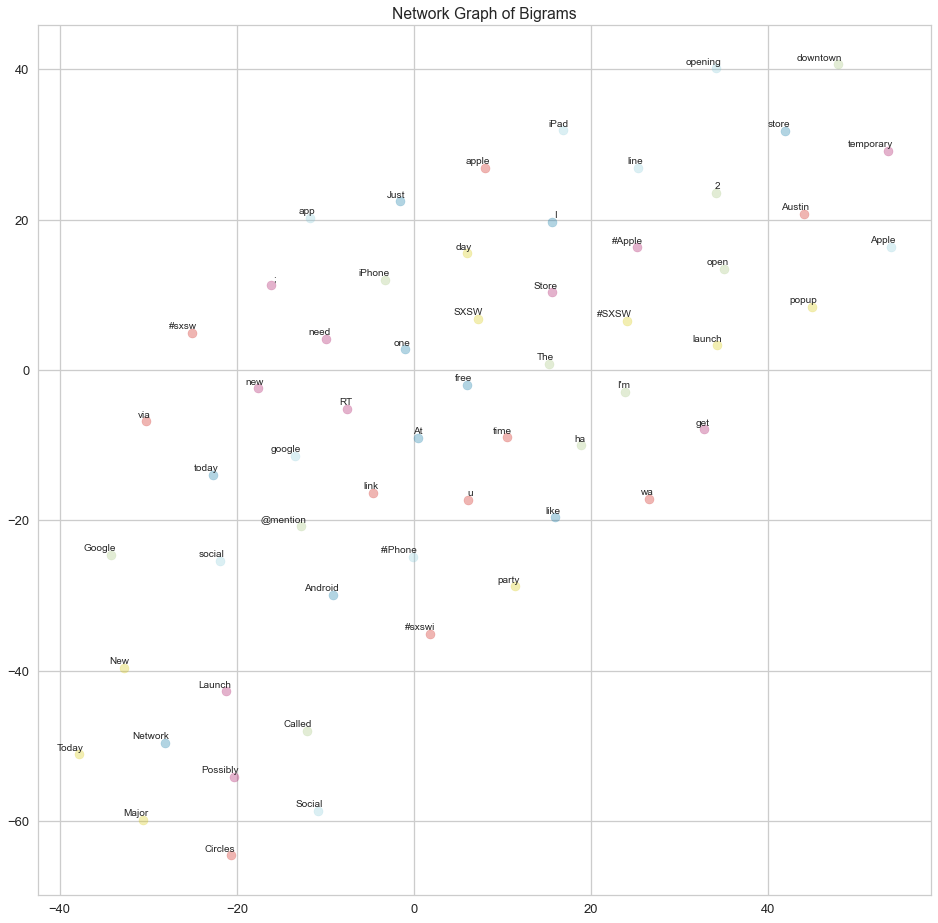

In [ ]:
def tsne_plot(model):
    "Creates TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], alpha=0.3)
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title("Network Graph of Bigrams")
    plt.show()
tsne_plot(model)

# Word2Vec Similarities and plots

## Google interpretation: 
Google's word similarities heavily center around the launch of the Circles network rumored at the time.

In [ ]:
google_similar = model.most_similar('Google')

google_similar

[('Possibly', 0.9860675930976868),
 ('New', 0.9844671487808228),
 ('Called', 0.982437014579773),
 ('Network', 0.9815248250961304),
 ('Circles', 0.9797247648239136),
 ('Today', 0.978994607925415),
 ('Major', 0.9776854515075684),
 ('Social', 0.9765462875366211),
 ('Launch', 0.9750221967697144),
 ('social', 0.9288997054100037)]

Text(0.5, 1.0, "Word Similarities to 'Google'")

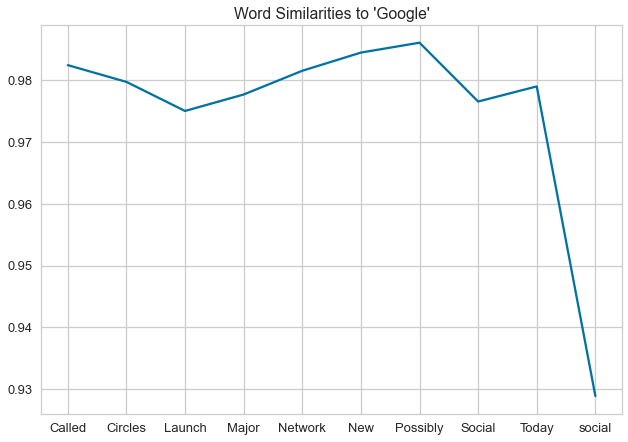

In [ ]:
sns.lineplot(*zip(*google_similar))
ax = plt.gca()
ax.set_title("Word Similarities to 'Google'")

## Apple interpretation:
Apple's word similarities heavily focus on the opening of a temporary popup store in downtown Austin and the iPad 2.

In [ ]:
apple_similar = model.most_similar('Apple')

Text(0.5, 1.0, "Word Similarities to 'Apple'")

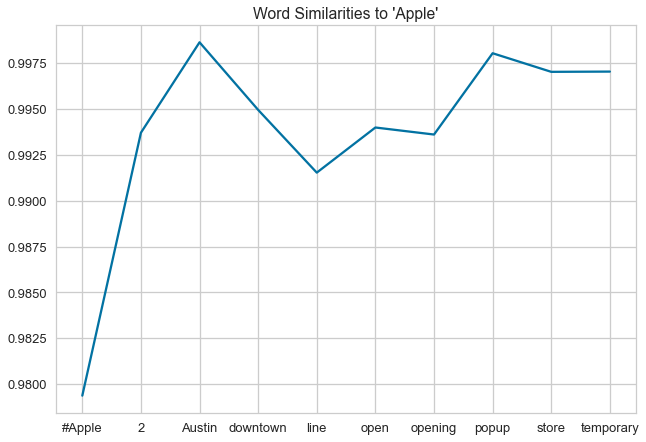

In [ ]:
sns.lineplot(*zip(*apple_similar))
ax = plt.gca()
ax.set_title("Word Similarities to 'Apple'")

# Bigrams

In [ ]:
from nltk import bigrams
from nltk import trigrams

In [ ]:
clean_df['tokens']

0       [@wesley83, I, 3G, iPhone, After, 3, hr, tweet...
1       [@jessedee, Know, @fludapp, ?, Awesome, iPad, ...
2       [@swonderlin, Can, wait, #iPad, 2, also, They,...
3       [@sxsw, I, hope, year's, festival, crashy, yea...
4       [@sxtxstate, great, stuff, Fri, #SXSW, Marissa...
                              ...                        
9088                      [Ipad, everywhere, #SXSW, link]
9089    [Wave, buzz, RT, @mention, We, interrupt, regu...
9090    [Google's, Zeiger, physician, never, reported,...
9091    [Some, Verizon, iPhone, customer, complained, ...
9092    [, Ï, ¡, , Ïà, , ü_, , , Ê, , , Î, , ...
Name: tokens, Length: 9092, dtype: object

In [ ]:
#create bigrams
bigram_list = [list(bigrams(tweet)) for tweet in clean_df['tokens']]

bigram_list[:6]

[[('@wesley83', 'I'),
  ('I', '3G'),
  ('3G', 'iPhone'),
  ('iPhone', 'After'),
  ('After', '3'),
  ('3', 'hr'),
  ('hr', 'tweeting'),
  ('tweeting', '#RISE_Austin'),
  ('#RISE_Austin', 'wa'),
  ('wa', 'dead'),
  ('dead', '!'),
  ('!', 'I'),
  ('I', 'need'),
  ('need', 'upgrade'),
  ('upgrade', 'Plugin'),
  ('Plugin', 'station'),
  ('station', '#SXSW')],
 [('@jessedee', 'Know'),
  ('Know', '@fludapp'),
  ('@fludapp', '?'),
  ('?', 'Awesome'),
  ('Awesome', 'iPad'),
  ('iPad', '/'),
  ('/', 'iPhone'),
  ('iPhone', 'app'),
  ('app', 'likely'),
  ('likely', 'appreciate'),
  ('appreciate', 'design'),
  ('design', 'Also'),
  ('Also', "they're"),
  ("they're", 'giving'),
  ('giving', 'free'),
  ('free', 'Ts'),
  ('Ts', '#SXSW')],
 [('@swonderlin', 'Can'),
  ('Can', 'wait'),
  ('wait', '#iPad'),
  ('#iPad', '2'),
  ('2', 'also'),
  ('also', 'They'),
  ('They', 'sale'),
  ('sale', '#SXSW')],
 [('@sxsw', 'I'),
  ('I', 'hope'),
  ('hope', "year's"),
  ("year's", 'festival'),
  ('festival', 'cras

In [ ]:
flat_bigrams = [item for sublist in bigram_list for item in sublist]

flat_bigrams[:11]

[('@wesley83', 'I'),
 ('I', '3G'),
 ('3G', 'iPhone'),
 ('iPhone', 'After'),
 ('After', '3'),
 ('3', 'hr'),
 ('hr', 'tweeting'),
 ('tweeting', '#RISE_Austin'),
 ('#RISE_Austin', 'wa'),
 ('wa', 'dead'),
 ('dead', '!')]

## Top 20 bigrams

## Interpretation:
The bigrams are dominated by phrases regarding this social network mentioned above, as well as the iPad2 and popup store again.

In [ ]:
import itertools
from collections import Counter

bigram_count = Counter(flat_bigrams)

bigram_count.most_common(20)

[(('RT', '@mention'), 2855),
 (('iPad', '2'), 986),
 (('@mention', '@mention'), 566),
 (('link', '#sxsw'), 513),
 (('#SXSW', 'link'), 453),
 (('@mention', 'Google'), 361),
 (('via', '@mention'), 346),
 (('Social', 'Network'), 308),
 (('New', 'Social'), 292),
 (('@mention', '#sxsw'), 278),
 (('Network', 'Called'), 277),
 (('Major', 'New'), 267),
 (('Launch', 'Major'), 266),
 (('!', 'link'), 258),
 (('Called', 'Circles'), 255),
 (('popup', 'store'), 254),
 (('Google', 'Launch'), 253),
 (('#sxsw', 'link'), 253),
 (('link', '#SXSW'), 243),
 (('Apple', 'Store'), 236)]

In [ ]:
bigram_df = pd.DataFrame(bigram_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

bigram  count
0         (RT, @mention)   2855
1              (iPad, 2)    986
2   (@mention, @mention)    566
3          (link, #sxsw)    513
4          (#SXSW, link)    453
5     (@mention, Google)    361
6        (via, @mention)    346
7      (Social, Network)    308
8          (New, Social)    292
9      (@mention, #sxsw)    278
10     (Network, Called)    277
11          (Major, New)    267
12       (Launch, Major)    266
13             (!, link)    258
14     (Called, Circles)    255
15        (popup, store)    254
16      (Google, Launch)    253
17         (#sxsw, link)    253
18         (link, #SXSW)    243
19        (Apple, Store)    236

## Plot of top 20 bigrams

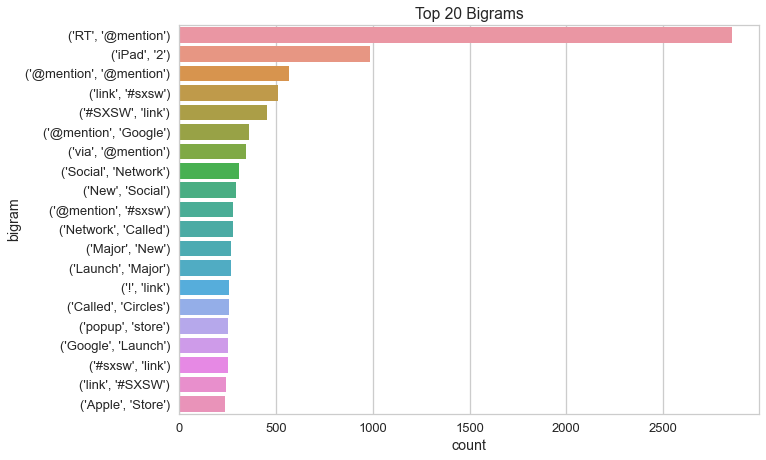

In [ ]:
sns.barplot(data=bigram_df, x="count", y="bigram")
ax = plt.gca()
ax.set_title("Top 20 Bigrams")
plt.show()

## Network plot of bigrams

### Interpretation: 
Clearly there's links between bigrams in tweets about the new social network, and the Apple popup store, when network graphed.

In [ ]:
import networkx as nx


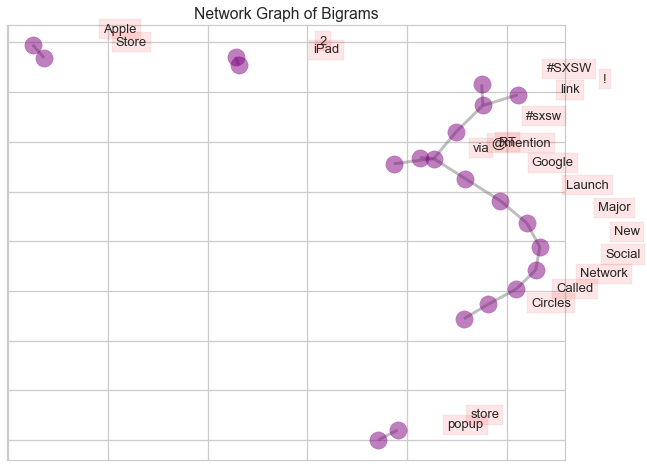

In [ ]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# G.add_node("apple", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2, seed=33)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax,
                alpha=0.5)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.175, value[1]+.050
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=13)
ax.set_title("Network Graph of Bigrams")
plt.show()

# Modeling

In [ ]:
from sklearn_pandas import DataFrameMapper, cross_val_score

## Making a scorer for grid searching out of cohen's kappa

In [ ]:
from sklearn.metrics import cohen_kappa_score, make_scorer
kappa_scorer = make_scorer(cohen_kappa_score)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB

## Function to run and compare LinearSVC and ComplementNB
### Rationale: 
Extensive early testing showed these two models to be the best compromise between performance and speed on this dataset without using tree-based methods(author's note: I utilized trees extensively in my last work, so I am forgoing them this time.)

In [ ]:
def classifier_comparison(X_train, y_train, X_test, y_test):
    '''A function that fits, predicts and outputs the Cohens Kappa of LinearSVC and ComplementNB'''
    ls = LinearSVC(random_state=0, class_weight="balanced")
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_test)
    ls_ck = cohen_kappa_score(y_test, y_pred)
    
    cnb = ComplementNB()
    cnb.fit(X_train, y_train)
    y_pred = cnb.predict(X_test)
    cnb_ck = cohen_kappa_score(y_test, y_pred)
    
    print("Cohen's Kappa of Linear SVC is " + str(ls_ck) + " and the Cohen's Kappa of ComplementNB is " + str(cnb_ck))
    

## DataFrameMapper with Tf-idf Vectorization
Note: DataFrameMapper creates a union between features, resulting in an array. 
- TF-IDF, put simply, is a vectorization technique that takes the number of times the word appears / the number of documents containing the words, most helpfullly normalizing word frequency by dividing by the document frequency to weight common words downwards as they appear many times but in many documents, vs. other permutations of frequencies. 

- Setting ngram_range to capture both unigrams and bigrams

In [ ]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer(ngram_range=(1, 2))),
     ('tweet_words', None),
    ('hash_cnt', None),
    ('mention_cnt', None),
    ('capital_words', None),
    ('excl_q_marks', None),
    ('mean_word_len',None),
    ('count_unique_word',None),
    ('word_unique_percent',None)
 ])

In [ ]:
X = mapper.fit_transform(clean_df)

In [ ]:
X

array([[  0.        ,   0.        ,   0.        , ...,   4.88235294,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.8125    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   4.55555556,
          9.        , 100.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   7.        ,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.5625    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,  10.33333333,
          9.        , 100.        ]])

## Train test splits
### Rationale: 
Standard practice, with stratifying on y to address class imbalance in splits.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

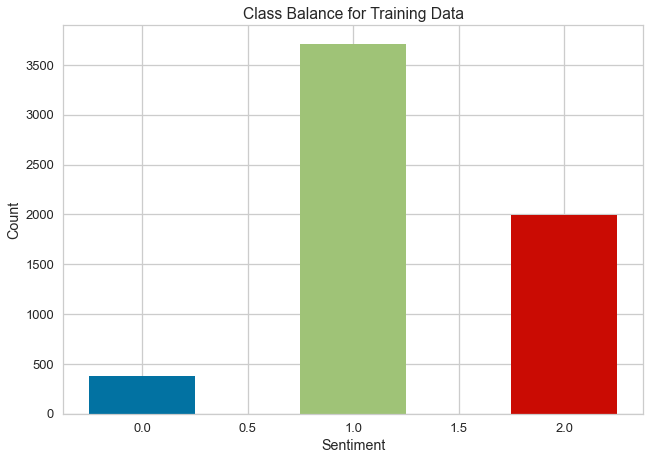

In [ ]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative","Neutral", "Positive"])
ax = plt.gca()
ax.set_title("Class Balance for Training Data")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")

visualizer.fit(y_train)
plt.show()

## Initial baseline modeling

In [ ]:
classifier_comparison(X_train, y_train, X_test, y_test)

Cohen's Kappa of Linear SVC is 0.018851586850255342 and the Cohen's Kappa of ComplementNB is 0.0


## Minmax Scaling
### Rationale: 
SVMs are 'scale sensitive'.

### Results: 
LinearSVC and ComplementNB both benefit greatly from scaling the data.

In [ ]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

In [ ]:
classifier_comparison(X_train, y_train, X_test, y_test)

Cohen's Kappa of Linear SVC is 0.32356410466364616 and the Cohen's Kappa of ComplementNB is 0.34657895653618687


### Interpreting Cohen's Kappa - an aside:

The range of values in even this snapshot of the array from dataframemapper shows the scale of the scaling involved - from 0 to 100 to 0 to 1 seems to make a great difference in the features being interpretable by the models. Note two scales of evaluation for Cohen's Kappa: 
- Landis and Koch  
    - 0-0.20 as slight, 0.21-0.40 as fair, 0.41-0.60 as moderate, 0.61-0.80 as substantial, and 0.81-1 as almost perfect. 
- Fleiss
 - 0.75 as excellent, 0.40-0.75 as fair to good, and < 0.40 as poor

### Demonstrating MinMax Scaling:
The range of values in even this snapshot of the array from dataframemapper shows the scale of the scaling involved - from 0 to 100 to 0 to 1 seems to make a great difference in the features being interpretable by the models.

In [ ]:
X

array([[  0.        ,   0.        ,   0.        , ...,   4.88235294,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.8125    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   4.55555556,
          9.        , 100.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   7.        ,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.5625    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,  10.33333333,
          9.        , 100.        ]])

In [ ]:
X_train

array([[0.        , 0.        , 0.94470948, ..., 0.24304963, 0.40909091,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.13320826, 0.18181818,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.15670979, 0.72727273,
        0.86315789],
       ...,
       [0.        , 0.        , 0.        , ..., 0.15947467, 0.31818182,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.24976548, 0.63636364,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.17589118, 0.27272727,
        1.        ]])

# Tuning SVC via. GridSearchCV
Tuning C, tolerance, and maximum iterations.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.1,1, 10, 100],'tol': [1e-3, 1e-4, 1e-5],
                        'max_iter': [1000, 10000]}

In [ ]:
linear_grid = GridSearchCV(LinearSVC(class_weight="balanced", random_state=0),param_grid,refit=True,verbose=2, scoring=kappa_scorer, n_jobs=-1)
linear_grid.fit(X_train,y_train)

In [ ]:
print(linear_grid.best_estimator_)

### Interpretation:
Grid searching has a noticeable effect with a balanced Linear SVC on the base dataset.

In [ ]:
linear_grid_predictions = linear_grid.predict(X_test)
linear_grid_bal_cohen = cohen_kappa_score(y_test, linear_grid_predictions)
print(linear_grid_bal_cohen)

## Tuning ComplementNB

In [ ]:
param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}

nb_grid = GridSearchCV(ComplementNB(),param_grid,refit=True,verbose=2, scoring=kappa_scorer, n_jobs=-1)
nb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.9min finished


GridSearchCV(estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [ ]:
nb_grid_predictions = nb_grid.predict(X_test)
print(metrics.classification_report(y_test,nb_grid_predictions))

              precision    recall  f1-score   support

           0       0.37      0.29      0.33       188
           1       0.73      0.80      0.76      1830
           2       0.60      0.52      0.55       983

    accuracy                           0.68      3001
   macro avg       0.57      0.54      0.55      3001
weighted avg       0.66      0.68      0.67      3001



In [ ]:
cohen_kappa_score(y_test, nb_grid_predictions)

0.34657895653618687

## On comparing models: 
Linear SVC seems to perform well on text classification on this dataset, along with ComplementNB right behind(.345 kappa). However, the number of parameters and tuning process in high dimensional feature space of Linear SVC limits its usefulness compared to the much faster Complement Naive Bayes without dimensionality reduction in place.

# Iterative KBest for feature selection:

## Hyperparameter tuning Complement NB

Originally 53309 features, we'll start at 5k features and make 5k steps up to 50,000

In [ ]:
X.shape

(9092, 53309)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
k_range = np.arange(start=5000, stop=50000, step=5000)

nb_best = []
nb_scores = []

for i in k_range:
    fs = SelectKBest(score_func=f_classif, k=i)
    X_selected = fs.fit_transform(X_train, y_train)
#     X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=42,stratify=y)
#     mm_scaler = preprocessing.MinMaxScaler()
#     X_train = mm_scaler.fit_transform(X_train)
#     X_test = mm_scaler.transform(X_test)
    nb_grid.fit(X_selected, y_train)
    X_test_selected = fs.transform(X_test)
    y_pred = nb_grid.predict(X_test_selected)
    print("Cohen's Kappa for " + str(i) + " features is:" + str(cohen_kappa_score(y_test,y_pred)) + "\n")
    nb_best.append(nb_grid.best_estimator_)
    nb_scores.append(nb_grid.best_score_)
    
nb_scores

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Cohen's Kappa for 5000 features is:0.2999496956918065

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   16.4s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.3s finished


Cohen's Kappa for 10000 features is:0.33364304200206407

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   26.6s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   47.5s finished


Cohen's Kappa for 15000 features is:0.32039623993235844

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   59.9s remaining:   59.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Cohen's Kappa for 20000 features is:0.3282062327448254

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


Cohen's Kappa for 25000 features is:0.33422010224905563

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Cohen's Kappa for 30000 features is:0.33190504186036995

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.7min finished


Cohen's Kappa for 35000 features is:0.32285364522018045

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.5min finished


Cohen's Kappa for 40000 features is:0.32913960037680956

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  4.0min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.6min finished


Cohen's Kappa for 45000 features is:0.35088485793984914



[0.5095108060939824,
 0.5429882547197821,
 0.4960563720740427,
 0.4847443228435925,
 0.4552305044127638,
 0.42086674892255943,
 0.39412948789394076,
 0.30058552736100186,
 0.2682644527160608]

In [ ]:
nb_score_max = max(range(len(nb_scores)), key=nb_scores.__getitem__)

nb_best = nb_best[nb_score_max]

nb_best

ComplementNB(alpha=1)

## Important note: 

This is very impressive performance by Complement NB with tuning, tuned LinearSVC has performed well, however with the computational load of tuning LinearSVC, ComplementNB has similar performance with more speed, though SVMs scale better to larger text in the literature (https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf), with more moving parts than the Naive Bayes family.

# Examination of feature importance on 'best' model - tuned Complement NB with K-best feature selection
## Note: 
I would have preferred to use a library such as ELI5, SHAP, or lesser so, LIME, but the ComplementNB class is not supported by ELI5, SHAP struggles in high dimensional background space, and LIME is non-deterministic of a single sample so not very useful for a high number of text features.

## Further note: 
As a Bayseian classifier, ComplementNB returns its coefficients in probabilities of predicting correctly. Selecting 50 features to start as a demonstration.

In [ ]:
coef = nb_best.coef_.ravel()
top_features = 50
top_pred_coef = np.argsort(coef)[-top_features:]

In [ ]:
nb_best

ComplementNB(alpha=1)

In [ ]:
top_pred_coef

array([2000, 1999, 4821, 6052, 4822, 1992, 6049, 1991, 8557, 8560, 8563,
       1980, 1979,   74, 2002, 9830, 2019, 8513, 8482, 8483, 2045, 2044,
       6077, 2042, 8491, 8492,  528, 6075, 2039, 2037, 6074, 4806, 8514,
       2034, 4807, 8505, 8506, 2031, 8507, 2027, 4810, 2026, 4811, 4813,
       2023, 2022, 2021, 2020, 6073, 2326])

In [ ]:
feature_names = mapper.transformed_names_

feature_names[:11]

['text_02',
 'text_02 symbian',
 'text_03',
 'text_03 10',
 'text_03 11',
 'text_03 12',
 'text_03 13',
 'text_03 14',
 'text_03 15',
 'text_03 applesetsuptemporarymegastoreatsxsw',
 'text_03 blackberry']

In [ ]:
top_pred_coef= np.array(top_pred_coef)
feature_names = np.array(feature_names)

## Interpretation: 
Oddly, occurrence of words and other metrics used for summary statistics and word visualization before do not seem to match up with predictive power, instead **perhaps(?)** contextualizing the tweets and what is being said **about** Apple and Google products. 

In [ ]:
feature_names[top_pred_coef]

array(['text_all lbs', 'text_all iphone', 'text_awareness sxsw',
       'text_bit quot', 'text_away', 'text_all better',
       'text_bit jealous', 'text_all apple', 'text_circle link',
       'text_circle opportunity', 'text_circle rumored',
       'text_alignd big', 'text_alignd', 'text_1030 am', 'text_all money',
       'text_controlled by', 'text_all unofficial', 'text_chromeo',
       'text_chortler', 'text_chortler cough', 'text_allows volunteer',
       'text_allows post', 'text_bitrate', 'text_allowing zoom',
       'text_chris rt', 'text_chris sacca', 'text_26svo3m',
       'text_bitly pushsxsw11', 'text_allowing delete', 'text_allowing',
       'text_bitly ieavob', 'text_awake trying', 'text_chromeo sxsw',
       'text_allow inapp', 'text_award', 'text_chrome mention',
       'text_chrome sway', 'text_allhat', 'text_chrome sxsw',
       'text_allen', 'text_awards', 'text_allcomfortfooddiet',
       'text_awards finalist', 'text_awards sxsw', 'text_all you',
       'text_all w

In [ ]:
pos_feat_names = np.array([x.split('_') for x in feature_names[top_pred_coef].ravel()])
pos_feat_names =[i[1] for i in pos_feat_names]

pos_feat_names

['all lbs',
 'all iphone',
 'awareness sxsw',
 'bit quot',
 'away',
 'all better',
 'bit jealous',
 'all apple',
 'circle link',
 'circle opportunity',
 'circle rumored',
 'alignd big',
 'alignd',
 '1030 am',
 'all money',
 'controlled by',
 'all unofficial',
 'chromeo',
 'chortler',
 'chortler cough',
 'allows volunteer',
 'allows post',
 'bitrate',
 'allowing zoom',
 'chris rt',
 'chris sacca',
 '26svo3m',
 'bitly pushsxsw11',
 'allowing delete',
 'allowing',
 'bitly ieavob',
 'awake trying',
 'chromeo sxsw',
 'allow inapp',
 'award',
 'chrome mention',
 'chrome sway',
 'allhat',
 'chrome sxsw',
 'allen',
 'awards',
 'allcomfortfooddiet',
 'awards finalist',
 'awards sxsw',
 'all you',
 'all wonder',
 'all welcome',
 'all way',
 'bitly i41h53',
 'amex']

## Feature importance - top positive predictive coefficients

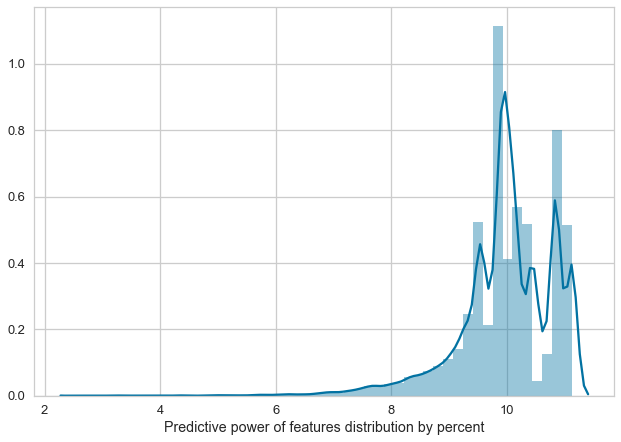

In [ ]:
ax = sns.distplot(coef, axlabel= "Predictive power of features distribution by percent")
plt.savefig("bayes_dist.png")
plt.show()

In [ ]:
np.quantile(coef, 0.95)

11.122394379248163

In [ ]:
np.quantile(coef, 0.99)

11.122394379248163

## Given that the top 95% contains roughly 2.6k word coefficients at about 11% predictive probability, this would be very difficult to visualize and the top 100 even arbitrary, instead taking a random sample

In [ ]:
# ninety_nine_coef = coef(np.where(coef > 11.12)
ninety_five_coef = np.where(coef > 11.12)[0]
# len(ninety_nine_coef )

In [ ]:
ninety_five_coef

array([  12,   13,   16, ..., 9970, 9973, 9991])

In [ ]:
np.random.seed(33)

sample_space = np.where(coef > 11.12)[0]

top_pred_coef = np.random.choice(sample_space, 50)

top_pred_coef

array([8762, 5223, 1689,  229, 7715,  345, 6846, 5214, 4229, 6422, 2327,
       5408, 4748, 2427, 9588, 5748, 8783, 1898, 5527, 4835, 5597, 1569,
        306, 8579, 2161, 1275, 1580, 2859,  338, 4841, 1863, 9791, 7826,
       1436, 4966,  746, 9290, 3498, 4738, 1944, 2805, 1367, 8229, 8529,
       2752, 6769, 1465,  218, 3608, 4796])

## Interpretation of positive predictive text: 
**NOTE: Some text features, being derived from preprocessed text, do not appear in the original dataframe.**

In [ ]:
idx = []
idxs = set()

#looping over feature names' coefficient, searching clean dataframe for index values containing
#produces idx, a list of lists, and idxs, a set containing no repeats as per sets

for c in feature_names[top_pred_coef]:
    i = clean_df[clean_df['text'].str.contains(c.split('_')[1])]
    if i.empty != True:
        idx.append(list(i.index.values))
        idxs.update(list(i.index.values))

print(idx)

[[3301, 5958], [1016], [70, 2515, 5779], [71], [334, 595, 1073, 2251, 2252, 2554, 6164, 7589, 8009], [3031, 6055], [8697], [1722], [4636, 6138], [347], [558, 1661, 1723, 1775, 2138, 2139, 3509, 3645, 4158, 4375, 4472, 4779, 4786, 4798, 5260, 5263, 5362, 6826, 7163, 7636, 7793, 7857, 8066, 8216, 8661], [193], [109, 969, 1805, 2881, 5182, 5196, 5197, 5325, 7186, 7629], [5923, 7866], [4349], [1563, 1813, 3781, 5421, 7946], [7385], [1547], [5174, 7817], [1428], [2464, 6206], [429, 5555], [7589], [135]]


In [ ]:
idxs

{70,
 71,
 109,
 135,
 193,
 334,
 347,
 429,
 558,
 595,
 969,
 1016,
 1073,
 1428,
 1547,
 1563,
 1661,
 1722,
 1723,
 1775,
 1805,
 1813,
 2138,
 2139,
 2251,
 2252,
 2464,
 2515,
 2554,
 2881,
 3031,
 3301,
 3509,
 3645,
 3781,
 4158,
 4349,
 4375,
 4472,
 4636,
 4779,
 4786,
 4798,
 5174,
 5182,
 5196,
 5197,
 5260,
 5263,
 5325,
 5362,
 5421,
 5555,
 5779,
 5923,
 5958,
 6055,
 6138,
 6164,
 6206,
 6826,
 7163,
 7186,
 7385,
 7589,
 7629,
 7636,
 7793,
 7817,
 7857,
 7866,
 7946,
 8009,
 8066,
 8216,
 8661,
 8697}

In [ ]:
len(idx)

24

In [ ]:
len(idxs)

77

In [ ]:
#https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
flatten = lambda l: [item for sublist in idx for item in sublist]

flat_idx = flatten(idx)

len(flat_idx)

78

## Original dataframe text
### Interpretation: 
- The iPad and Apple seem to win the day, contextualizing and being contextualized by the coefficients unigrams and bigrams predicting tweets about it. 

In [ ]:
#display the values of the corresponding indices in the original dataframe
with pd.option_context('display.max_colwidth', 250):
    print(df['text'][flat_idx].values)

['haha Google serving pies at the #sxsw booth at 3/14 159 pm'
 'RT @mention haha Google serving pies at the #sxsw booth at 3/14 159 pm'
 'Wordpress powers 12% of websites (from #SXSW talk from WP founder)  WOW  The other 88%?  russian spam bots nigerian bankers google'
 'Check! RT @mention giving added value to location based services needs to battle checkin fatigue #google #pnid #sxsw'
 'giving added value to location based services needs to battle checkin fatigue #google #pnid #sxsw'
 'RT @mention giving added value to location based services needs to battle checkin fatigue #google #pnid #sxsw'
 'Chilcott @mention #SXSW stand talking with Blogger staff Too late to win competition for best tweet mentioning @mention So no tshirt'
 "knackered at home playing with ipad and updating iphone but timeline smashed with partytweets can't make me go to bed #sxsw"
 'Ironic? I googled the directions to @mention party and ended up walked 6 blocks in the wrong direction Time for bed I think #SXSW'


## Creating a list of important words from EDA and checking occurrences in final coefficients flat indices

In [ ]:
keywords= ['iPad 2', "Social Network", "New Social", "Network Called", "Major New", "Launch Major", "Called Circles", "popup store", "Google Launch", "Apple Store", 'Circles']

keywords

['iPad 2',
 'Social Network',
 'New Social',
 'Network Called',
 'Major New',
 'Launch Major',
 'Called Circles',
 'popup store',
 'Google Launch',
 'Apple Store',
 'Circles']

In [ ]:
flat_idx[:11]

[3301, 5958, 1016, 70, 2515, 5779, 71, 334, 595, 1073, 2251]

In [ ]:
important_df = df[df.index.isin(flat_idx)]

important_df.head()

text  sentiment  tweet_len  \
70   Check! RT @mention giving added value to locat...          1        116   
71   Chilcott @mention #SXSW stand talking with Blo...          1        132   
109  Kawasaki &quot;Not CS Lewis level reasoning bu...          2        133   
135  Take that #SXSW ! RT @mention Major South Kore...          2        116   
193  many iPad 2's snapping away at the keynote sli...          2         56   

     tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
70            18         3            1              1             1   
71            21         1            2              1             0   
109           19         2            0              1             0   
135           21         1            1              2             1   
193           10         1            0              0             1   

     mean_word_len  count_unique_word  word_unique_percent  
70        5.500000                 17            94.444444  
71        5.333333                 20            95.238095  
109       6.052632                 18            94.736842  
135       4.571429                 21           100.000000  
193       4.700000                 10           100.000000

## Interpretation:
It looks like while they occurr frequently, with the iPad 2 showing up most of all, the model did not find them to be extremely predictive, likely due to inverting the term document frequency and their high rate of occurrence.

In [ ]:
keyword_counter = 0

for i in keywords:
    count = important_df['text'].str.count(i).sum()
    if count != 0:
        print(i + " has " + str(count) + " occurrences")
        keyword_counter = 0
    print("Sum total of occurrences is: "+ str(keyword_counter))

iPad 2 has 3 occurrences
Sum total of occurrences is: 0
Social Network has 1 occurrences
Sum total of occurrences is: 0
New Social has 1 occurrences
Sum total of occurrences is: 0
Sum total of occurrences is: 0
Sum total of occurrences is: 0
Sum total of occurrences is: 0
Sum total of occurrences is: 0
Sum total of occurrences is: 0
Sum total of occurrences is: 0
Sum total of occurrences is: 0
Circles has 2 occurrences
Sum total of occurrences is: 0


# Top 95% Coefficients

In [ ]:
idx = []
idxs = set()

#looping over feature names' coefficient, searching clean dataframe for index values containing
#produces idx, a list of lists, and idxs, a set containing no repeats as per sets

for c in feature_names[ninety_five_coef]:
    i = clean_df[clean_df['text'].str.contains(c.split('_')[1])]
    if i.empty != True:
        idx.append(list(i.index.values))
        idxs.update(list(i.index.values))

print(idx)

[[7117], [2325], [3902], [2124, 4243, 5046, 6024], [3523, 6863], [1142, 1143], [459, 556, 1318, 8882], [4685, 6972, 7220], [1203, 1489, 2869, 3216, 3217, 3218, 3219, 4078, 4809, 5162, 5163, 5558, 7820, 8494, 8685], [3676, 6427], [3399, 3693, 5282, 6497, 6601], [119, 180, 1184, 3500, 3861, 5363, 7393, 8242], [4031], [4525], [1511], [22, 7870], [1667, 3454], [404, 2000, 5348, 5512, 6953], [404, 5512, 6953], [6953], [265, 1919, 6730], [265, 6730], [7782, 7812], [7149], [4442, 4708, 8755], [7686, 8388], [2499], [325, 1581, 2557, 2888, 3096, 3255, 3480, 3926, 4335, 4795, 5120, 5349, 5390, 5683, 6075, 6111, 6413, 6458, 6599, 8484, 8982], [4430, 6070, 6071], [3512], [4634], [1982, 6914, 6946, 7108], [1076, 4135], [135, 1636, 7931, 8080, 8169], [8169], [135, 1636], [135], [3301, 5958], [3327], [1982, 6946], [868, 4505, 6019, 6702, 7693], [4163], [4163], [2387, 6196, 8938], [2387, 6196, 8938], [4757], [4398, 4399, 4745, 6608, 6675], [4826], [2070], [186], [7797], [7797], [954, 1081, 1257, 1351,

In [ ]:
flatten = lambda l: [item for sublist in idx for item in sublist]

flat_idx = flatten(idx)

len(flat_idx)

91672

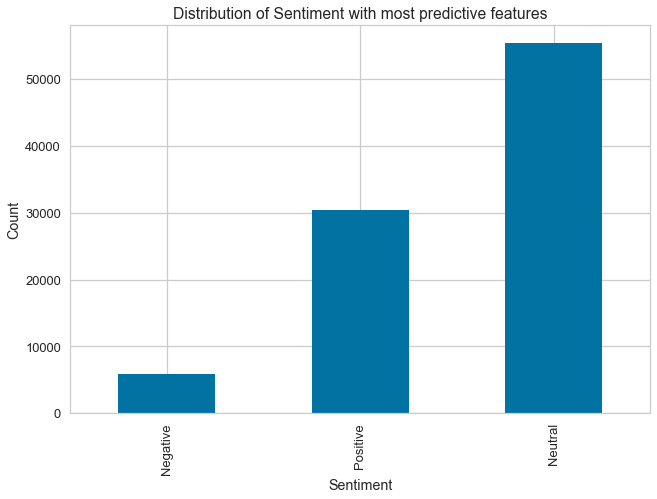

In [ ]:
df['sentiment'][flat_idx].value_counts().sort_values().plot(kind="bar")
ax = plt.gca()
ax.set_xticklabels(["Negative", "Positive", "Neutral"])
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_title("Distribution of Sentiment with most predictive features")
plt.savefig("topcoefdist.png")
plt.show()

# Undersampling techniques

In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [ ]:
from imblearn.under_sampling import NearMiss 
print('Original dataset shape %s' % Counter(y))
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

In [ ]:
model = LinearSVC(class_weight="balanced", random_state=0)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

In [ ]:
bal_nm_cohen = cohen_kappa_score(y_test,y_pred)
print(bal_nm_cohen)

## Grid search on undersampling

In [ ]:
nb_grid.fit(X_res,y_res)

In [ ]:
grid_predictions = nb_grid.predict(X_test)

In [ ]:
grid_nm_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_nm_cohen)

# Other undersampling techniques - 
NeighbourhoodCleaningRule was trained and found to be rather computationally expensive without dimensionality reduction, and produces results that don't outperform the dataset with no resampling, like the other undersampling techniques.

In [ ]:
# from imblearn.under_sampling import NeighbourhoodCleaningRule
# ncr = NeighbourhoodCleaningRule()
# X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
# print(sorted(Counter(y_resampled).items()))

In [ ]:
# nb_grid.fit(X_res,y_res)
# grid_predictions = nb_grid.predict(X_test)

In [ ]:
# grid_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)
# print(grid_ncr_cohen)

## Interpetation: 
- No undersampling techniques seem to benefit performance of the ComplementNB model after reducing feature space.
- A note about SMOTE: Despite good results in the last round of imbalanced classification I undertook as a project, SMOTE and its variants were not used as they synthetically create text that is not within the original dataset.

# Conclusions - 

## Best model results and interpretation:
### Results: 
- Achieved fair or moderately reliable score with ComplementNB in a reduced feature space through SelectKBest.
- This classifier struggled, even with weighting of classes, stratification, attempts at resapling through undersampling and more, with the heavy imbalance in the data. 
- All other classifiers struggled with the imbalance as well, the key impedement to performance in classification in this task. 
- Issues with the feasability of tuning LinearSVC and SGDClassifier led to using ComplementNB, similar performance without having to reduce the dimensionality further through something like PCA and sacrifice interpretability.
- Moving forward with this project and model, I would seek to better address imbalance.

### Interpretation: 
- Interpretation was made difficult by performance issues, especially on the negative class, and its low support, as well as the use of bigrams and the difference between the preprocessed and raw dataframe. 
- With that said, trends emerged in the EDA: the big showings of Apple and Google respectively with their popup store along with the iPad 2 and the rumored Circles social network contributed to positive ratings, while design critiques of the iPad 2 stood out in the negative class in EDA. 
- Likely due to the workings of TF-IDF, the model itself focused on other coefficients, contextualizing that Apple predominated with its iPad 2 showing with a large number of equally predictive coefficients.

## Business recomendations: 

### 1. Go Big: 
- The trends that stood out in the exploratory data analysis were big showings by Apple and Google during an important event. It is crucial to capitalize on hype and make bold moves during periods like SXSW: whether it be drumming up the launch of a new social network or creating a popup store. 

### 2. Data Integrity: 
- The analysis was heavily compromised by data issues. Data collection and labeling must be done with an eye towards class balance and adequate support. 

### 3. Focus on the tangible and reliable:
- The iPad 2 was a common theme among the text corresponding to the coefficients. Having an actual product as opposed to the rumors of Circles seems to have helped Apple considerably to win positive sentiment. Furthermore, utilize models such as ComplementNB that show how predictive a feature is to derive what are reliably predictive features.

# Future work: 
## Outlier detection approaches:
- Imbalanced learning can be treated as an outlier detection problem. 
- I would like to explore this through techniques such as Isolation Forest. 
- As well, I would look into adding additional features based off of the outlier and inlier values produced by those techniques to boost model performance.

## Multilabel classification
- This dataset could have been posed as a multilabel classification problem, by using the feature regarding direction of the tweet. 
- I would like to examine the various approaches to multilabel classification and see if they yielded better or different results and in what sense. 

# Sources: **Incomplete**
- https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf
- https://www.datacamp.com/community/tutorials/feature-selection-python
- https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/
- https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf
- https://youtu.be/NEaUSP4YerM
- https://youtu.be/efR1C6CvhmE
- https://www.youtube.com/watch?v=O2L2Uv9pdDA
- https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
- https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/
- Develops on and adapts own work in: https://github.com/MichaelBurak/crunchbase-analysis

# Future TO DOs:

- Presentation 
    - Note any code that’s been repurposed and its source
    - Clean up + move imports up to top  


- Important to notebook
    - Compare metrics between different classifiers, sampling strategies
    - implement early stopping on iterative kbest
    - chart of model performance in various scenarios
    - PCA

- Details, can be dropped/modified
    - Detail what min max scaling does and how SVMs are ‘scale sensitive’
    - Interpretation of word model tsne plot 
    - More thorough explanation of cohen’s kappa and evaluation 

- Later:
    - Blog post
    - Video
    - Do something about @ and mention?
    - Trigrams  and n grams
    -  LDA modeling